# USING METHOD OF MOMENTS TO PREDICT DATABASE PERFORMANCE METRICS

## Introduction

This article exploits statistical technique method of moments (MOM) and generalized method of moments (GMM)  to estimate database statistics from the past data. Both GMM and MOM's are parametric  unsupervised form of learning. I am restricting this to Oracle Database in this example, but it can be extended to any database system.

We initially select a distribution to model our random variable. Our random variables in database statistical parameters could be any statistic that we collect say in AWR report. To start our analysis, we collected AWR reports over several months. We then scraped these data and stored our metrics in csv formats. I have presented some csv files corresponding to these statistics in my github page.


## Parameters Of Interest

Lets say we want to use the method of moments to predict the following AWR statistics for the database Load Profile in AWR statistics. This is given in this section.

In [96]:
%matplotlib inline
from IPython.display import Image
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
from plotly import tools
import scipy.stats as scs
from scipy.stats import *
from scipy import stats
import plotly.plotly as py
from plotly.graph_objs import *
import numpy as np
pd.set_option('display.max_columns', 10)

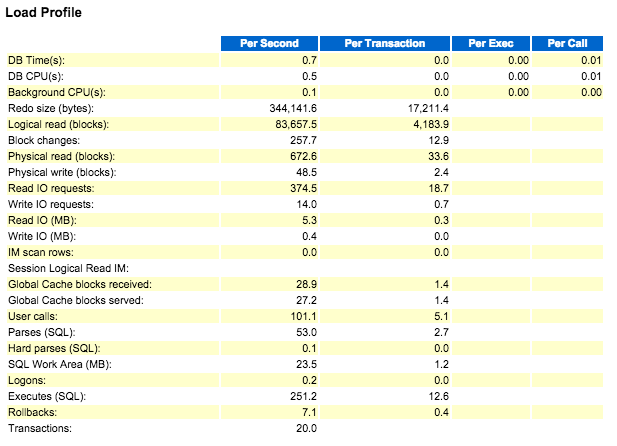

In [2]:
Image(filename='images/load_profile.png')

Reading our historic load profile data in the dataframe.

In [3]:
df=pd.read_csv('data/TMP_AWR_LOAD_PROFILE_AGG.csv', sep='|',parse_dates=True)
df.head()

,site_id,config_id,run_id,stat_id,stat_name,stat_per_sec,stat_per_txn,stat_per_exec,stat_per_call,start_time
0,37,1,1,265418,Global Cache blocks received,4467.21,16.36,NaN,NaN,03-OCT-14 08.00.00.000000 AM
1,37,1,1,265427,Transactions,274.49,NaN,NaN,NaN,03-OCT-14 08.00.00.000000 AM
2,37,1,1,265410,Logical read (blocks),291880.19,1064.87,NaN,NaN,03-OCT-14 08.00.00.000000 AM
3,37,1,1,265419,Global Cache blocks served,4467.02,16.34,NaN,NaN,03-OCT-14 08.00.00.000000 AM
4,37,1,1,265421,Parses (SQL),1131.04,4.14,NaN,NaN,03-OCT-14 08.00.00.000000 AM


As we can we have the data for several statistics viz. Global Cache blocks received, Transactions, Logical read (blocks), Global Cache blocks served, etc from the AWR load profile start from date 03-OCT-14  until 02-NOV-15.
I am interested in forecasting only stat_per_sec information on this AWR Load profile, so using pivot function in pandas we get the following reconstructed dataframe.      

In [4]:
df=df.pivot_table(index='start_time', columns='stat_name', values='stat_per_sec')
df.head()

stat_name,Background CPU(s),Block changes,DB CPU(s),DB Time(s),Executes (SQL),...,Session Logical Read IM,Transactions,User calls,Write IO (MB),Write IO requests
start_time,,,,,,,,,,,
01-APR-15 08.00.00.000000 AM,2.34,7171.66,8.34,21.33,7295.85,...,NaN,342.13,3172.36,7.38,791.23
01-APR-15 10.00.00.000000 PM,1.88,5829.02,5.75,14.98,4943.24,...,NaN,243.01,2288.04,5.59,603.88
01-JAN-15 08.00.00.000000 AM,NaN,1746.34,1.80,4.07,2277.13,...,NaN,139.59,970.47,1.61,162.10
01-JUL-15 08.00.00.000000 AM,2.07,6530.64,6.92,18.46,6485.98,...,NaN,334.05,3064.53,6.76,721.93
01-JUL-15 10.00.00.000000 PM,1.80,5853.14,5.19,14.20,4787.97,...,NaN,259.02,2370.28,5.70,606.48


In [5]:
print (df.columns)

Index([u'Background CPU(s)', u'Block changes', u'DB CPU(s)', u'DB Time(s)',
       u'Executes (SQL)', u'Global Cache blocks received',
       u'Global Cache blocks served', u'Hard parses (SQL)', u'IM scan rows',
       u'Logical read (blocks)', u'Logons', u'Parses (SQL)',
       u'Physical read (blocks)', u'Physical write (blocks)', u'Read IO (MB)',
       u'Read IO requests', u'Redo size (bytes)', u'Rollbacks',
       u'SQL Work Area (MB)', u'Session Logical Read IM', u'Transactions',
       u'User calls', u'Write IO (MB)', u'Write IO requests'],
      dtype='object', name=u'stat_name')


## Distribution Selection

All of these database statistics are continous random variables, so we model using some continous distributions.
scipy offers several continous distributions for the purpose of modelling, viz Gamma, Normal, Anglit, Arcsine, Beta, Cauchy etc.

Once we have the estimated model, we can then use the Kolmogorov-Smirov test to evaluate your fit using scipy.stats.kstest. Lets start with the most popular gamma distribution.

Say I am interested in Background CPU(s) information, calculating the gamma distribution parameters alpha and beta.


In [6]:
sample_mean=df['Background CPU(s)'].mean()
sample_var=np.var(df['Background CPU(s)'], ddof=1)
(sample_mean,sample_var)

(2.157353689567431, 0.23047410162538273)

Alphas and Betas of Gamma distribution:

In [7]:
###############
#### Gamma ####
###############

alpha = sample_mean**2 / sample_var
beta = sample_mean / sample_var 
alpha,beta

(20.19391727342622, 9.360503737092497)

## MOM Estimation

Using estimated parameters and plot the distribution on top of data

In [8]:
gamma_rv = scs.gamma(a=alpha, scale=1/beta)

In [9]:
# Get the probability for each value in the data
x_vals = np.linspace(df['Background CPU(s)'].min(), df['Background CPU(s)'].max())
gamma_p = gamma_rv.pdf(x_vals)

In [10]:
df.head()

stat_name,Background CPU(s),Block changes,DB CPU(s),DB Time(s),Executes (SQL),...,Session Logical Read IM,Transactions,User calls,Write IO (MB),Write IO requests
start_time,,,,,,,,,,,
01-APR-15 08.00.00.000000 AM,2.34,7171.66,8.34,21.33,7295.85,...,NaN,342.13,3172.36,7.38,791.23
01-APR-15 10.00.00.000000 PM,1.88,5829.02,5.75,14.98,4943.24,...,NaN,243.01,2288.04,5.59,603.88
01-JAN-15 08.00.00.000000 AM,NaN,1746.34,1.80,4.07,2277.13,...,NaN,139.59,970.47,1.61,162.10
01-JUL-15 08.00.00.000000 AM,2.07,6530.64,6.92,18.46,6485.98,...,NaN,334.05,3064.53,6.76,721.93
01-JUL-15 10.00.00.000000 PM,1.80,5853.14,5.19,14.20,4787.97,...,NaN,259.02,2370.28,5.70,606.48


In [97]:
# Generate random colormap
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in xrange(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

Number of labels: 50


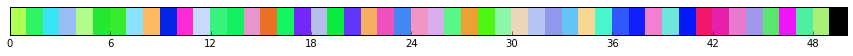

In [98]:
bright_cmap = rand_cmap(50, type='bright', first_color_black=False, last_color_black=True, verbose=True)

Number of labels: 50


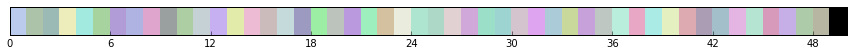

In [99]:
soft_cmap = rand_cmap(50, type='soft', first_color_black=False, last_color_black=True, verbose=True)

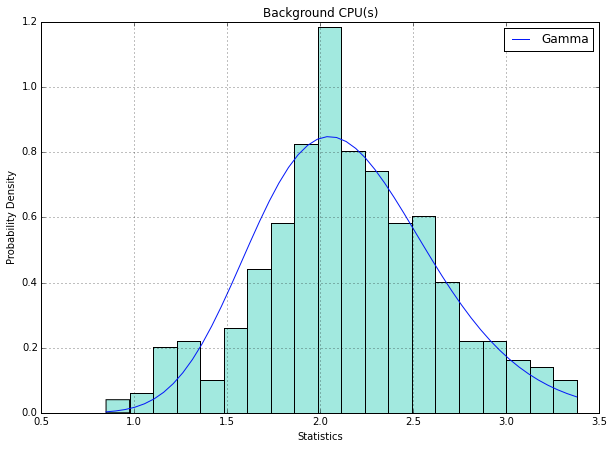

In [110]:
'''Use the estimated parameters and plot the distribution on top of data'''
fig, ax = plt.subplots()
col=soft_cmap(random.choice(range(50)))
# Plot those values on top of the real data
ax = df['Background CPU(s)'].hist(bins=20, normed=1, color=col, figsize=(10, 7))
ax.set_xlabel('Statistics')
ax.set_ylabel('Probability Density')
ax.set_title('Background CPU(s)')
col=bright_cmap(random.choice(range(50)))
ax.plot(x_vals,  gamma_p, c=col, label='Gamma')
ax.set_axis_bgcolor('white')
ax.legend()
#py.iplot_mpl(fig, filename='s6_log-scales')

In [111]:
# Lets put everything in a function 
# Define a function that plots distribution fitted to one month's of data
def plot_mom(df, col):
    sample_mean=df[col].mean()
    sample_var=np.var(df[col], ddof=1)
    alpha = sample_mean**2 / sample_var
    beta = sample_mean / sample_var 
    gamma_rv = scs.gamma(a=alpha, scale=1/beta)
    # Get the probability for each value in the data
    x_vals = np.linspace(df[col].min(), df[col].max())
    gamma_p = gamma_rv.pdf(x_vals)
    fig, ax = plt.subplots()
    # Plot those values on top of the real data
    mycol=soft_cmap(random.choice(range(50)))
    ax = df[col].hist(bins=20, normed=1, color=mycol, figsize=(10, 7))
    ax.set_axis_bgcolor('white')
    ax.set_xlabel('Statistics')
    ax.set_ylabel('Probability Density')
    ax.set_title(col)
    mycol=bright_cmap(random.choice(range(50)))
    ax.plot(x_vals, gamma_p, color=mycol, label='Gamma')
    ax.legend()

In [105]:
df.columns

Index([u'Background CPU(s)', u'Block changes', u'DB CPU(s)', u'DB Time(s)',
       u'Executes (SQL)', u'Global Cache blocks received',
       u'Global Cache blocks served', u'Hard parses (SQL)', u'IM scan rows',
       u'Logical read (blocks)', u'Logons', u'Parses (SQL)',
       u'Physical read (blocks)', u'Physical write (blocks)', u'Read IO (MB)',
       u'Read IO requests', u'Redo size (bytes)', u'Rollbacks',
       u'SQL Work Area (MB)', u'Session Logical Read IM', u'Transactions',
       u'User calls', u'Write IO (MB)', u'Write IO requests'],
      dtype='object', name=u'stat_name')

Lets just pick the following important statistics to estimate:
	* 'Background CPU(s)'
	* 'DB CPU(s)',
	* 'Executes (SQL)',
	* 'IM scan rows',
	* 'Hard parses (SQL)',
	* 'Logical read (blocks)',
	* 'Parses (SQL)',
	* 'Physical read (blocks)',
	* 'Physical write (blocks)'

In [106]:
columns_of_interest=['Background CPU(s)', 'DB CPU(s)', 'Executes (SQL)', 'User calls', 'Hard parses (SQL)', 'Logical read (blocks)', 'Parses (SQL)', 'Physical read (blocks)', 'Physical write (blocks)']

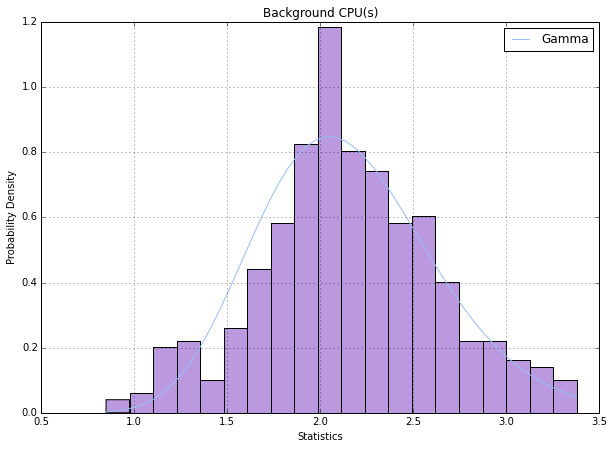

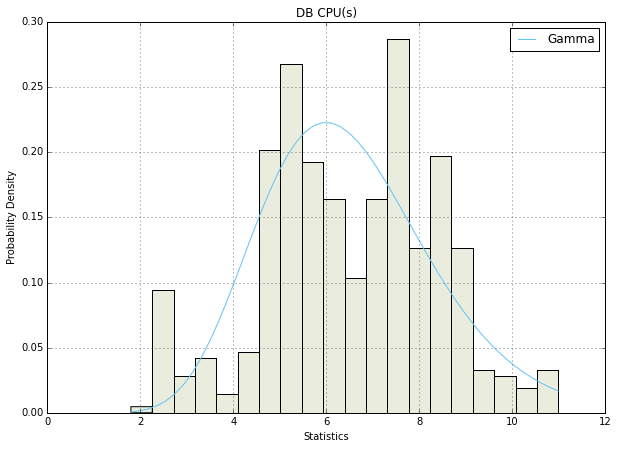

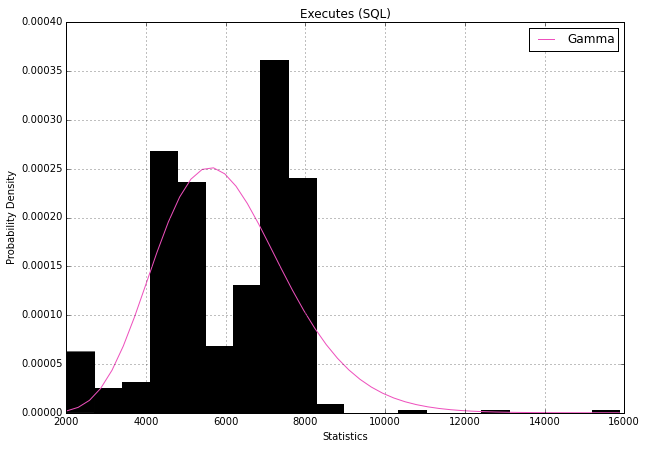

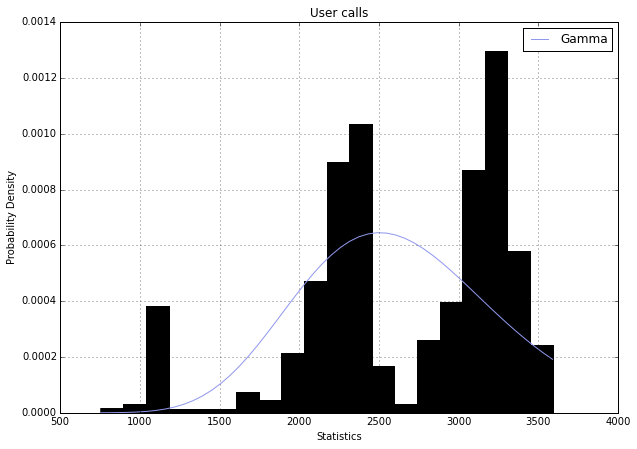

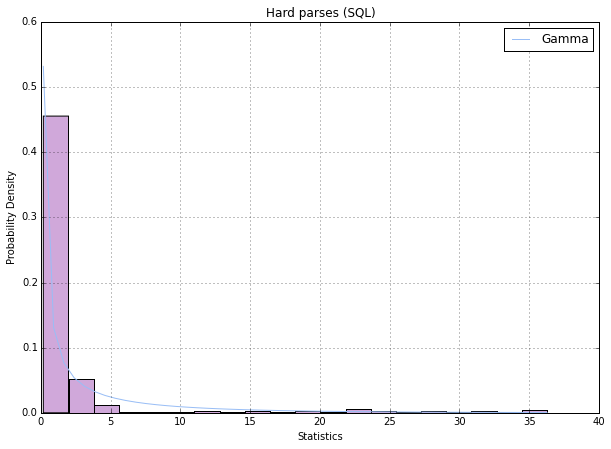

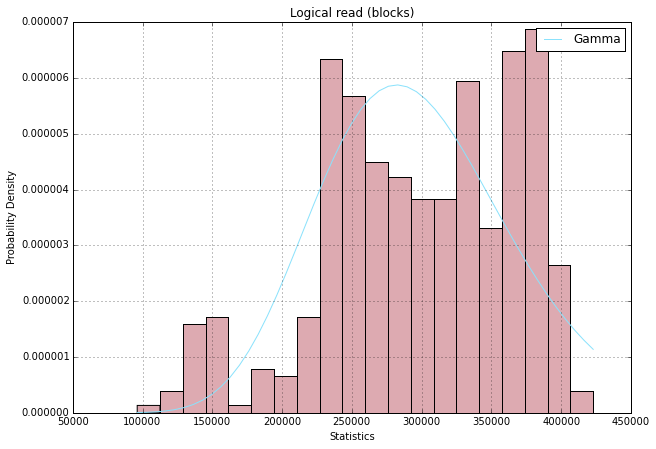

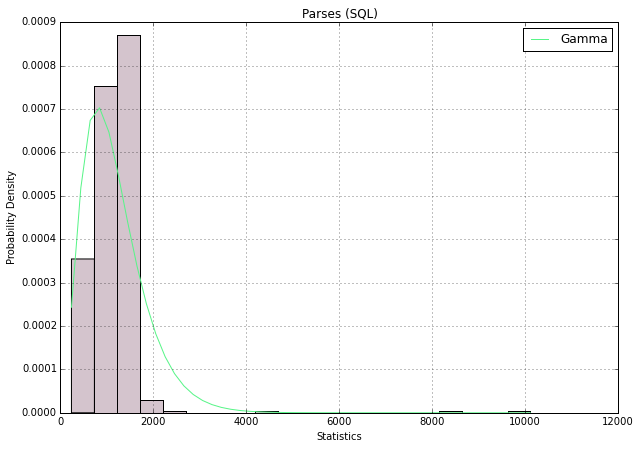

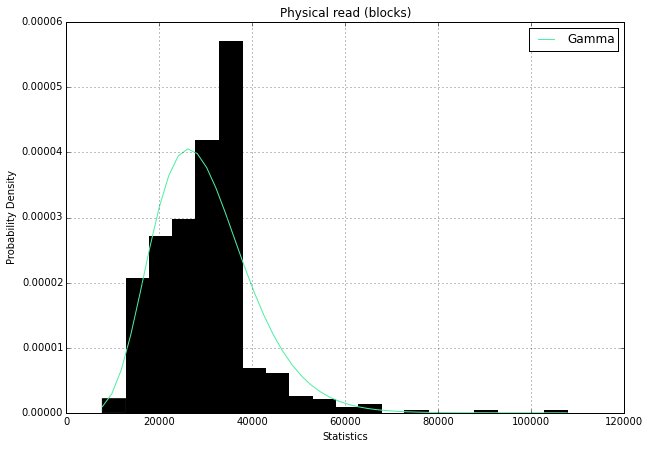

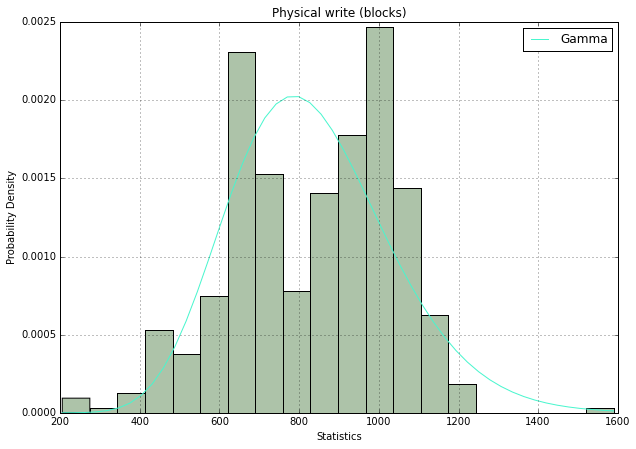

In [112]:
for col in columns_of_interest:
    plot_mom(df, col)
    fig.savefig('images/'+col)

In [26]:
df.head()

stat_name,Background CPU(s),Block changes,DB CPU(s),DB Time(s),Executes (SQL),...,Session Logical Read IM,Transactions,User calls,Write IO (MB),Write IO requests
start_time,,,,,,,,,,,
01-APR-15 08.00.00.000000 AM,2.34,7171.66,8.34,21.33,7295.85,...,NaN,342.13,3172.36,7.38,791.23
01-APR-15 10.00.00.000000 PM,1.88,5829.02,5.75,14.98,4943.24,...,NaN,243.01,2288.04,5.59,603.88
01-JAN-15 08.00.00.000000 AM,NaN,1746.34,1.80,4.07,2277.13,...,NaN,139.59,970.47,1.61,162.10
01-JUL-15 08.00.00.000000 AM,2.07,6530.64,6.92,18.46,6485.98,...,NaN,334.05,3064.53,6.76,721.93
01-JUL-15 10.00.00.000000 PM,1.80,5853.14,5.19,14.20,4787.97,...,NaN,259.02,2370.28,5.70,606.48


This above function would generate the MOM estimate for any database statistic that we would want.
For example if we want to predict MOM's for "Global Cache blocks served", we just need to call this function:

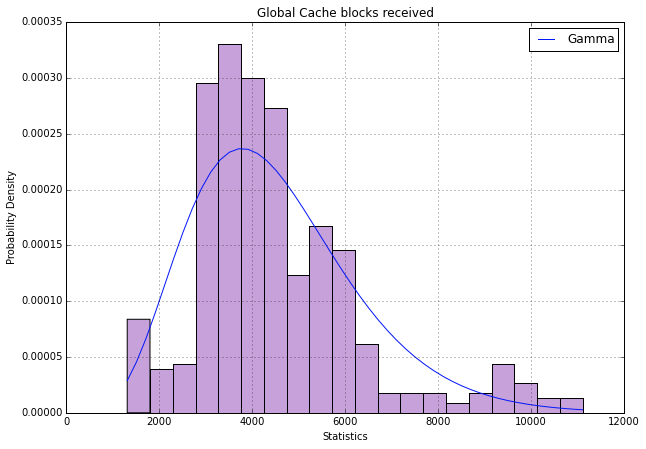

In [113]:
plot_mom(df,'Global Cache blocks received')
fig.savefig('images/cache_blocks.png')

For "Rollbacks" example our estimation is:

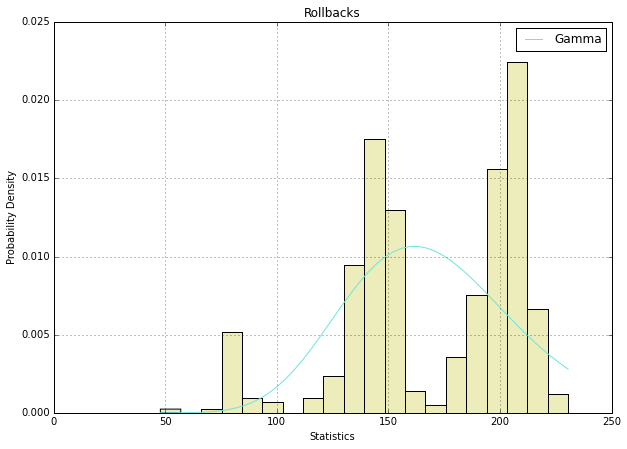

In [114]:
plot_mom(df,'Rollbacks')
fig.savefig('images/rollbacks.png')

## Conclusion:

As we can we our estimations (plotted in red) are pretty good estimation of our actual values that we observe in our real outputs. This concludes our discussion on MOM estimators on database statistics.